In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
# from darts.models import VARIMA
# from darts.models import RNNModel
# from darts.metrics import mae
# from darts.timeseries import TimeSeries
from sklearn.model_selection import train_test_split
from genrisk.generation import TCNVAE
from genrisk.utils.create_immutable_features import AddImmutable
import torch
from torch.utils.data import Dataset

# DATA

In [31]:
data = pd.read_csv('/home/coder/project/data_ETT/ETTh1.csv')
m2 = pd.read_csv('/home/coder/project/data_ETT/ETTm2.csv')

In [32]:
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [33]:
time_col = 'date'
value_cols = ['HUFL','HULL','MUFL','MULL','LUFL','LULL','OT']

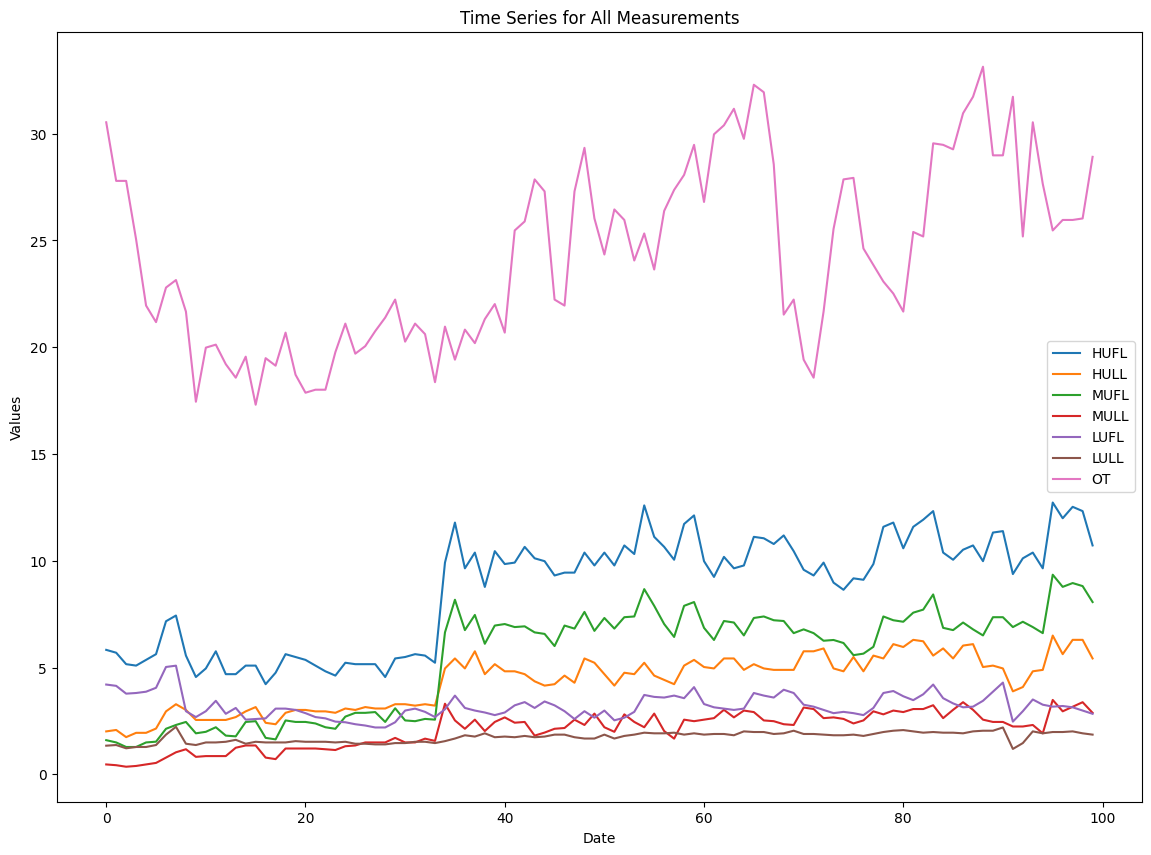

In [34]:
data_plot = data[:100]

plt.figure(figsize=(14, 10))
for column in value_cols:
    plt.plot(data_plot.index, data_plot[column], label=column)

plt.title('Time Series for All Measurements')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [35]:
train_size = int(len(data) * 0.7)
val_size = train_size+ int(len(data) * 0.1)
train_data = data[:train_size]
val_data = data[train_size:val_size]
test_data = data[val_size:]

In [36]:
train_data[time_col] = pd.to_datetime(train_data[time_col]) 
train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)

test_data[time_col] = pd.to_datetime(test_data[time_col])
test_data['time_idx'] = ((test_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)

val_data[time_col] = pd.to_datetime(val_data[time_col])
val_data['time_idx'] = ((val_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)


/home/coder/tmp/ipykernel_352/1915035461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[time_col] = pd.to_datetime(train_data[time_col])
/home/coder/tmp/ipykernel_352/1915035461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)
/home/coder/tmp/ipykernel_352/1915035461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [37]:
train_data = pd.melt(
    train_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [38]:
train_data

,date,time_idx,group_col,value
0,2016-07-01 00:00:00,0,HUFL,5.827
1,2016-07-01 01:00:00,1,HUFL,5.693
2,2016-07-01 02:00:00,2,HUFL,5.157
3,2016-07-01 03:00:00,3,HUFL,5.090
4,2016-07-01 04:00:00,4,HUFL,5.358
...,...,...,...,...
85353,2017-11-20 21:00:00,12189,OT,5.135
85354,2017-11-20 22:00:00,12190,OT,4.924
85355,2017-11-20 23:00:00,12191,OT,5.065
85356,2017-11-21 00:00:00,12192,OT,4.854


In [39]:
test_data = pd.melt(
    test_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [40]:
test_data

,date,time_idx,group_col,value
0,2018-02-01 16:00:00,13936,HUFL,3.684
1,2018-02-01 17:00:00,13937,HUFL,13.329
2,2018-02-01 18:00:00,13938,HUFL,15.606
3,2018-02-01 19:00:00,13939,HUFL,18.687
4,2018-02-01 20:00:00,13940,HUFL,18.018
...,...,...,...,...
24383,2018-06-26 15:00:00,17415,OT,10.904
24384,2018-06-26 16:00:00,17416,OT,11.044
24385,2018-06-26 17:00:00,17417,OT,10.271
24386,2018-06-26 18:00:00,17418,OT,9.778


In [41]:
val_data = pd.melt(
    val_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

# FORECASTING

In [42]:
from torch.utils.data import Dataset

class SlidingWindowDataset(Dataset):
    def __init__(self, df, target_columns, window_size, step_size):
        self.window_size = window_size
        self.target_columns = target_columns
        self.df = df
        self.step_size = step_size
    
    def __len__(self):
        return (len(self.df) - self.window_size + 1) // self.step_size
    
    def __getitem__(self, idx):
        target = self.df[self.target_columns].iloc[range(idx*self.step_size, idx*self.step_size + self.window_size)]
        return torch.FloatTensor(target.values)


In [43]:
# import os
# import torch
# from torch.utils.data import DataLoader
# from pytorch_forecasting import Baseline, TemporalFusionTransformer, LSTM
# from pytorch_forecasting.metrics import MAE
# import pandas as pd
# import lightning.pytorch as pl

# max_encoder_length = 24*4*3
# max_prediction_length = 24*4
# # Константы для параметров модели
# BATCH_SIZE = 64
# EPOCHS = 20
# LEARNING_RATE = 1e-3
# WINDOW_SIZE = max_encoder_length + max_prediction_length
# STEP_SIZE = 1

# # Создаем датасеты с использованием SlidingWindowDataset
# dataset_train = SlidingWindowDataset(train_data, target_columns=['value'], window_size=WINDOW_SIZE, step_size=STEP_SIZE)
# dataset_test = SlidingWindowDataset(test_data, target_columns=['value'], window_size=WINDOW_SIZE, step_size=STEP_SIZE)

# # Создаем DataLoader для train и test
# dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
# dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# # Функция для сохранения модели и параметров
# def save_model(model, model_name, output_dir="models"):
#     os.makedirs(output_dir, exist_ok=True)
#     model_path = os.path.join(output_dir, f"{model_name}.pth")
#     params_path = os.path.join(output_dir, f"{model_name}_params.txt")

#     # Сохранение модели
#     torch.save(model.state_dict(), model_path)

#     # Сохранение параметров
#     with open(params_path, "w") as f:
#         for key, value in model.hparams.items():
#             f.write(f"{key}: {value}\n")
#     print(f"Model and parameters saved for {model_name}")

# # LSTM Model
# # lstm = LSTM(
# #     hidden_size=64,
# #     input_size=len(['value']),
# #     #learning_rate=LEARNING_RATE,
# #     #log_interval=10,
# #     #log_val_interval=1,
# #     #loss=MAE(),
# # )
# # trainer = pl.Trainer(max_epochs=EPOCHS)
# # trainer.fit(lstm, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# # save_model(lstm, "LSTM")

# # TemporalFusionTransformer Model
# tft = TemporalFusionTransformer(
#     hidden_size=64,
#     learning_rate=LEARNING_RATE,
#     log_interval=10,
#     log_val_interval=1,
#     loss=MAE(),
#     max_encoder_length=max_encoder_length,
#     #max_prediction_length=max_prediction_length,
# )
# trainer.fit(tft, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# save_model(tft, "TemporalFusionTransformer")

# # Baseline Model
# baseline = Baseline(loss=MAE())
# trainer.fit(baseline, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# save_model(baseline, "Baseline")


In [44]:
# import os
# import torch
# from torch.utils.data import DataLoader
# from pytorch_forecasting import Baseline, TemporalFusionTransformer, LSTM, TimeSeriesDataSet
# from pytorch_forecasting.metrics import MAE
# import pandas as pd
# import lightning.pytorch as pl

# # Константы для параметров модели
# BATCH_SIZE = 64
# EPOCHS = 20
# LEARNING_RATE = 1e-3
# WINDOW_SIZE = max_encoder_length + max_prediction_length
# STEP_SIZE = 1

# # Создаем датасеты с использованием TimeSeriesDataSet
# dataset_train = TimeSeriesDataSet(
#     train_data,
#     time_idx='time_idx',
#     group_ids=['group_col'],
#     target='value',
#     max_encoder_length=max_encoder_length, 
#     max_prediction_length=max_prediction_length,
#     time_varying_unknown_reals=['value'],
#     time_varying_known_reals=['time_idx'],
#     allow_missing_timesteps=True
# )

# dataset_test = TimeSeriesDataSet(
#     test_data,
#     time_idx='time_idx',
#     group_ids=['group_col'],
#     target='value',
#     max_encoder_length=max_encoder_length, 
#     max_prediction_length=max_prediction_length,
#     time_varying_unknown_reals=['value'],
#     time_varying_known_reals=['time_idx'],
#     allow_missing_timesteps=True
# )

# # Создаем DataLoader для train и test
# dataloader_train = dataset_train.to_dataloader(train=True, batch_size=BATCH_SIZE, shuffle=True)
# dataloader_test = dataset_test.to_dataloader(train=False, batch_size=BATCH_SIZE, shuffle=False)

# # Функция для сохранения модели и параметров
# def save_model(model, model_name, output_dir="models"):
#     os.makedirs(output_dir, exist_ok=True)
#     model_path = os.path.join(output_dir, f"{model_name}.ckpt")
#     model.save_checkpoint(model_path)
#     print(f"Model and parameters saved for {model_name}")

# # Функция для загрузки модели и параметров
# def load_model(model_class, model_name, output_dir="models"):
#     model_path = os.path.join(output_dir, f"{model_name}.ckpt")
#     model = model_class.load_from_checkpoint(model_path)
#     print(f"Model {model_name} loaded from {model_path}")
#     return model

# # # LSTM Model
# # lstm = LSTM.from_dataset(
# #     dataset_train,
# #     hidden_size=64,
# #     learning_rate=LEARNING_RATE,
# #     log_interval=10,
# #     log_val_interval=1,
# #     loss=MAE(),
# # )
# # trainer = pl.Trainer(max_epochs=EPOCHS, gpus=torch.cuda.device_count())
# # trainer.fit(lstm, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# # save_model(lstm, "LSTM")

# # TemporalFusionTransformer Model
# tft = TemporalFusionTransformer.from_dataset(
#     dataset_train,
#     hidden_size=64,
#     learning_rate=LEARNING_RATE,
#     log_interval=10,
#     log_val_interval=1,
#     loss=MAE(),
#     max_encoder_length=max_encoder_length,
#     #max_prediction_length=max_prediction_length,
# )
# trainer.fit(tft, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# save_model(tft, "TemporalFusionTransformer")

# # Baseline Model
# baseline = Baseline.from_dataset(
#     dataset_train,
#     loss=MAE(),
# )
# trainer.fit(baseline, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)
# save_model(baseline, "Baseline")

# # Загрузка моделей
# loaded_lstm = load_model(LSTM, "LSTM")
# loaded_tft = load_model(TemporalFusionTransformer, "TemporalFusionTransformer")
# loaded_baseline = load_model(Baseline, "Baseline")


In [45]:
# baseline_model = Baseline()

# baseline_predictions = baseline_model.predict(dataloader_test, return_y=True)
# print(baseline_predictions.output.shape)
# print(baseline_predictions.y[0].shape)


# MAE()(baseline_predictions.output.reshape(-1), baseline_predictions.y[0])

In [46]:
import copy
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import torch

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE

# Параметры
max_encoder_length = 24 * 3 * 4
max_prediction_length = 24 * 4

# Подготовка данных
dataset_train = TimeSeriesDataSet(
    train_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataset_val = TimeSeriesDataSet(
    val_data,  # добавлен валидационный датасет
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataset_test = TimeSeriesDataSet(
    test_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataloader_train = dataset_train.to_dataloader(train=True, batch_size=64, num_workers=0)
dataloader_val = dataset_val.to_dataloader(train=False, batch_size=64, num_workers=0)
dataloader_test = dataset_test.to_dataloader(train=False, batch_size=64, num_workers=0)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # выполнять обучение за 50 батчей
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Модель TemporalFusionTransformer
tft = TemporalFusionTransformer.from_dataset(
    dataset_train,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 15.5k


/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless 

In [81]:
# Обучение модели
trainer.fit(
    tft,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val,
)

# Сохранение модели
model_save_path = "tft_model_h.ckpt"
trainer.save_checkpoint(model_save_path)
print(f"Model saved to {model_save_path}")

You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 1g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 32     | train
4  | static_variable_selection 

Epoch 34: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s, v_num=6, train_loss_step=3.280, val_loss=2.620, train_loss_epoch=3.460]
Model saved to tft_model_h.ckpt


In [47]:
model_save_path = "tft_model_h.ckpt"
tft = TemporalFusionTransformer.load_from_checkpoint(model_save_path)
print("Model loaded successfully")

Model loaded successfully


In [82]:
def test_model(model, dataloader_test):
    metrics_list = []
    
    # Прогон модели по тестовому датасету
    result = trainer.test(model, dataloaders=dataloader_test)
    metrics = result[0]  # Результаты из первого элемента (если многократные результаты)
    
    metrics_list.append(metrics)
    
    # Преобразование метрик в DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv("test_metrics_h.csv", index=False)

# Тестирование модели
test_metrics_avg = test_model(tft, dataloader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 340/340 [01:05<00:00,  5.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE            2.7340545654296875
        test_MAPE               1005299.125
        test_RMSE           3.4632909297943115
       test_SMAPE           0.6233395338058472
        test_loss           3.4632909297943115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [48]:
# import copy
# from pathlib import Path
# import warnings

# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from lightning.pytorch.loggers import TensorBoardLogger
# import numpy as np
# import pandas as pd
# import torch

# from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE

# max_encoder_length = 24*3*4
# max_prediction_length = 24*4

# dataset_train = TimeSeriesDataSet(
#     train_data,
#     time_idx='time_idx',
#     group_ids=['group_col'],
#     target='value',
#     max_encoder_length=max_encoder_length, 
#     max_prediction_length=max_prediction_length,
#     time_varying_unknown_reals=['value'],
#     time_varying_known_reals=['time_idx'],
#     allow_missing_timesteps=True
# )

# dataset_test = TimeSeriesDataSet(
#     test_data,
#     time_idx='time_idx',
#     group_ids=['group_col'],
#     target='value',
#     max_encoder_length=max_encoder_length, 
#     max_prediction_length=max_prediction_length,
#     time_varying_unknown_reals=['value'],
#     time_varying_known_reals=['time_idx'],
#     allow_missing_timesteps=True
# )

# dataloader_train = dataset_train.to_dataloader(train=True, batch_size=64, num_workers=0)
# dataloader_test = dataset_test.to_dataloader(train=False, batch_size=64, num_workers=0)

# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=50,
#     accelerator="gpu",
#     enable_model_summary=True,
#     gradient_clip_val=0.1,
#     limit_train_batches=50,  # coment in for training, running valiation every 30 batches
#     # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     dataset_train,
#     learning_rate=0.03,
#     hidden_size=16,
#     attention_head_size=2,
#     dropout=0.1,
#     hidden_continuous_size=8,
#     loss=RMSE(),
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



# trainer.fit(
#     tft,
#     train_dataloaders=dataloader_train,
#     val_dataloaders=dataloader_test,
# )

# VAE

conditional

In [49]:
train_size = int(len(data) * 0.7)
val_size = train_size+ int(len(data) * 0.1)
train_data = data[:train_size]
val_data = data[train_size:val_size]
test_data = data[val_size:]

In [50]:
train_data[time_col] = pd.to_datetime(train_data[time_col]) 
train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)

/home/coder/tmp/ipykernel_352/3102534669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[time_col] = pd.to_datetime(train_data[time_col])
/home/coder/tmp/ipykernel_352/3102534669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['time_idx'] = ((train_data[time_col] - train_data[time_col].min()).dt.total_seconds() // 3600).astype(int)


In [51]:
train_data_immutable = train_data.copy()
train_data_immutable = train_data_immutable.set_index('date')
train_data_immutable.index = pd.to_datetime(train_data_immutable.index)
train_data_immutable = AddImmutable(train_data_immutable, ['hoursofday']).get()

In [52]:
train_data.set_index('date', inplace=True)

In [53]:
train_data_immutable.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,time_idx,hoursofday_cos,hoursofday_sin
date,,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0,1.000000,0.000000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1,0.965926,0.258819
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2,0.866025,0.500000
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,3,0.707107,0.707107
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,4,0.500000,0.866025


In [54]:
value_cols

['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

In [75]:
gen = TCNVAE(
    target_columns=value_cols, 
    conditional_columns=['hoursofday_cos', 'hoursofday_sin'],
    hidden_dim=16,
    latent_dim=1,
    num_layers=2,
    kernel_size=3,
    window_size=40,
    batch_size=256,
    num_epochs=2,
    verbose=True,
    lr=0.001,
)
gen.fit(train_data_immutable)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params | Mode 
---------------------------------------------
0 | enc  | _TCNEncoder | 3.0 K  | train
1 | dec  | _TCNDecoder | 2.7 K  | train
---------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/48 [00:00<?, ?it/s] 

Epoch 1: 100%|██████████| 48/48 [00:13<00:00,  3.65it/s, v_num=16, train_loss=3.08e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 48/48 [00:13<00:00,  3.64it/s, v_num=16, train_loss=3.08e+3]


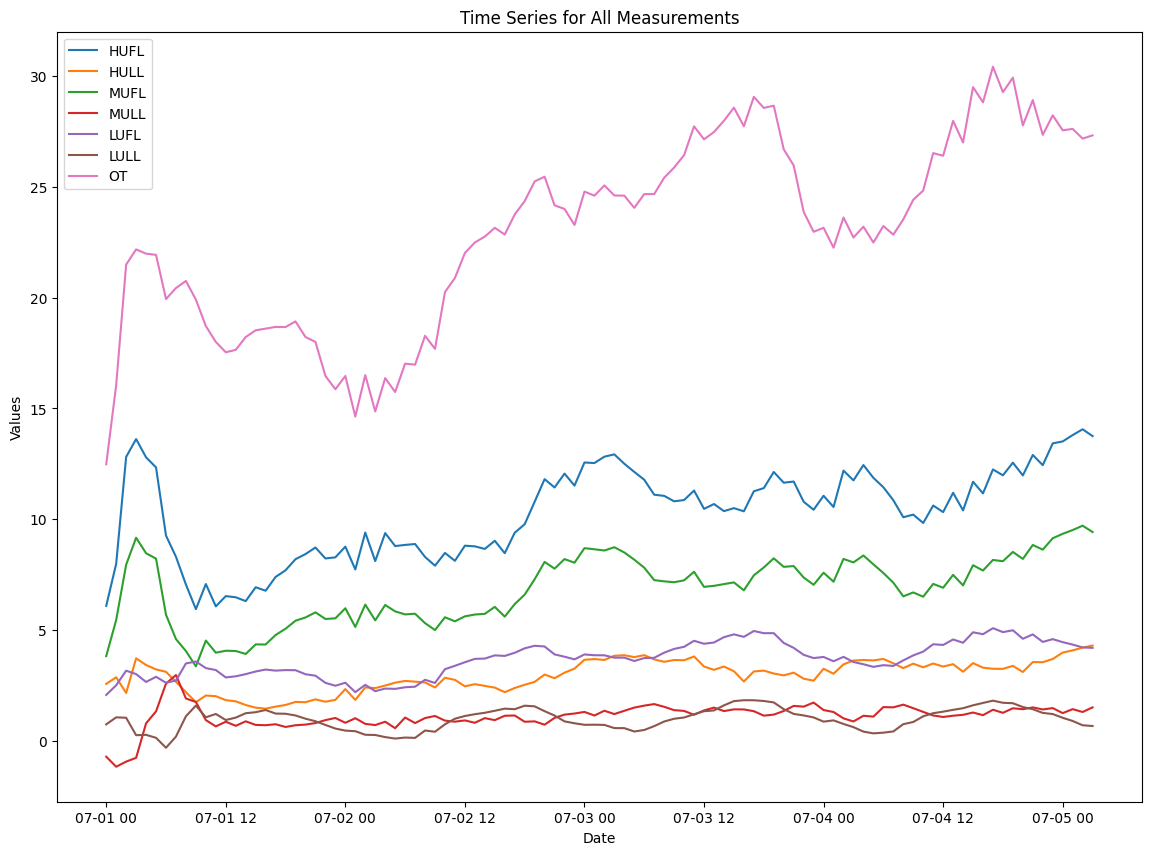

In [76]:
fake_data = gen.sample(train_data_immutable, n_samples=10)
data_plot = fake_data[0][:100]

plt.figure(figsize=(14, 10))
for column in value_cols:
    plt.plot(data_plot.index, data_plot[column], label=column)

plt.title('Time Series for All Measurements')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# AUGMENTATION WITH VAE

conditional

In [77]:
fake_data = gen.sample(train_data_immutable, n_samples=1)[0]

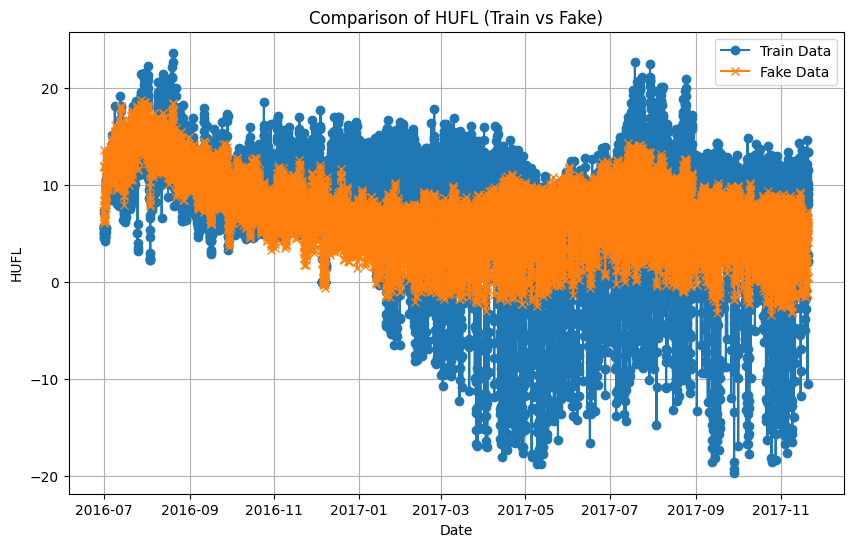

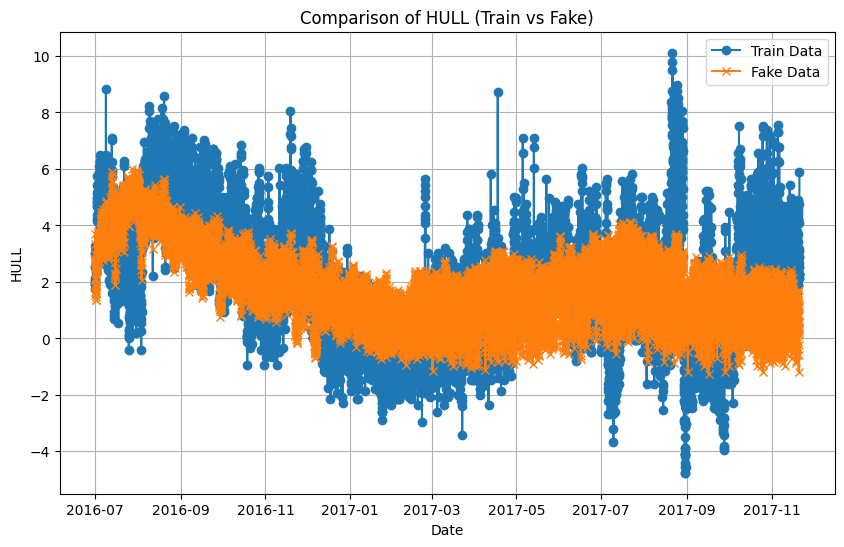

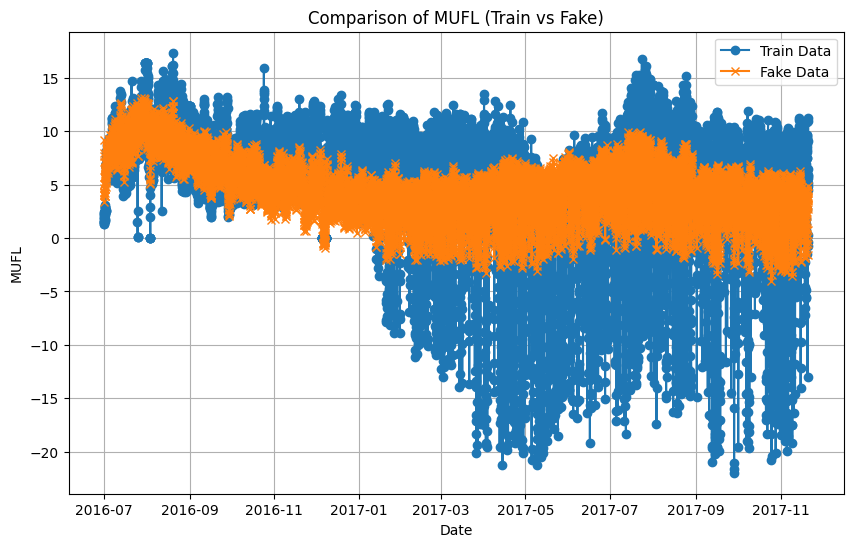

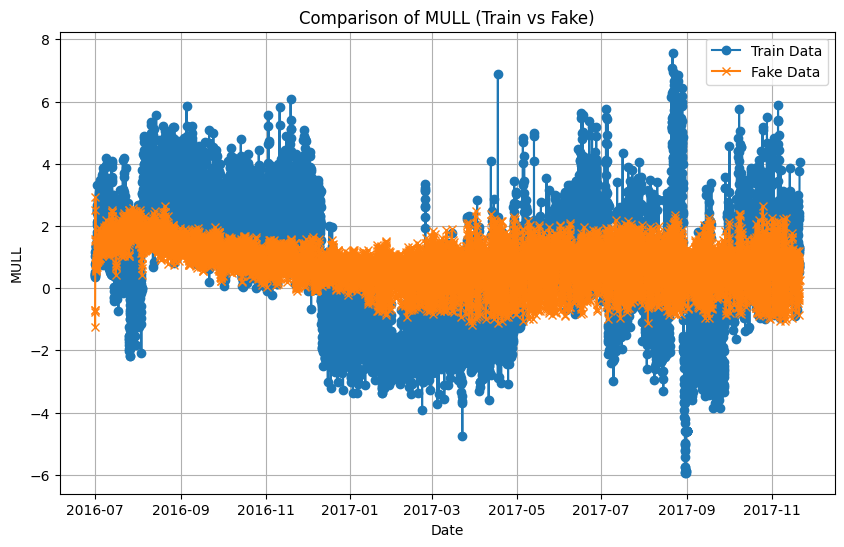

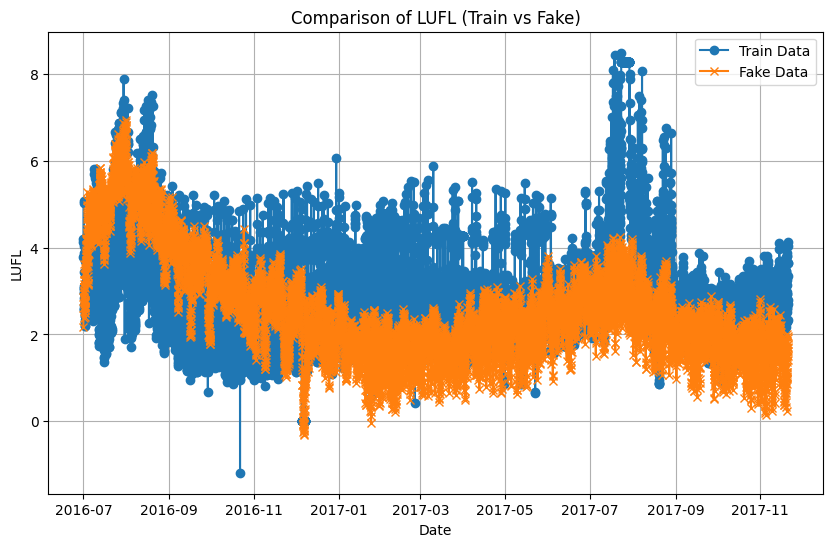

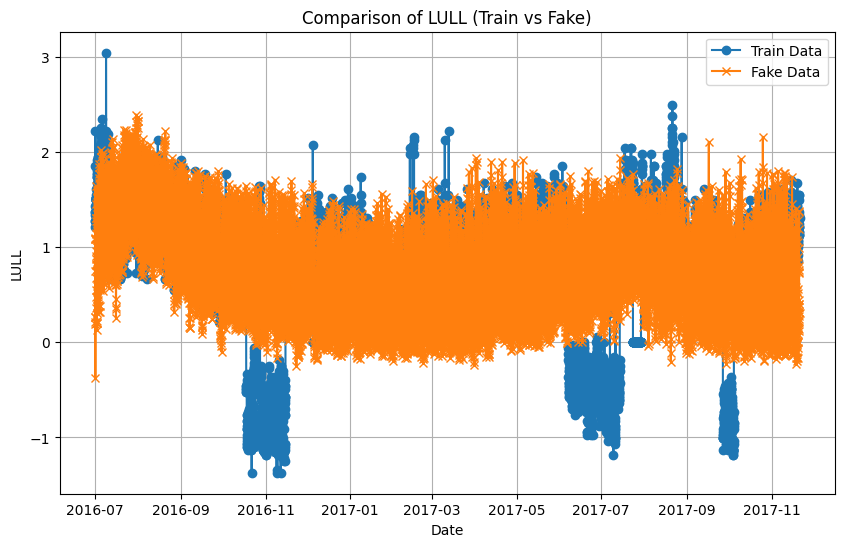

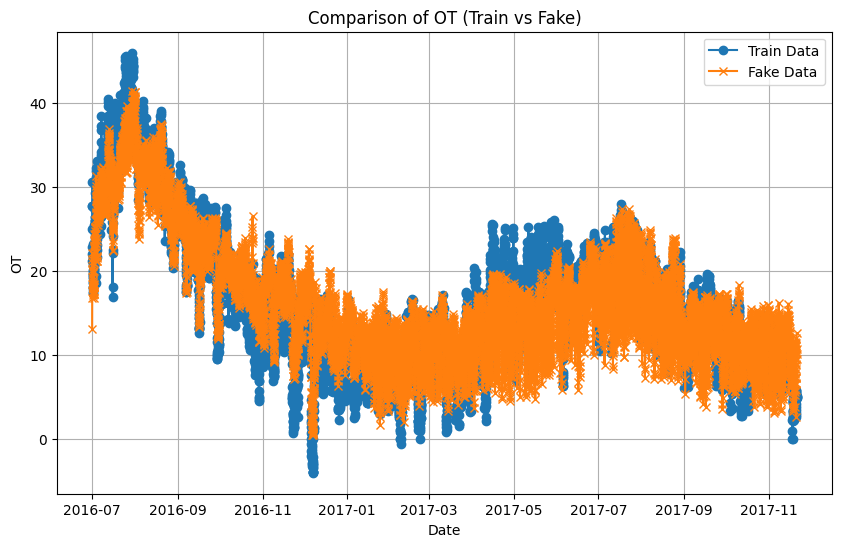

In [78]:
columns_to_plot = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

# Plot the data
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data[column], label='Train Data', marker='o')
    plt.plot(fake_data.index, fake_data[column], label='Fake Data', marker='x')
    plt.title(f'Comparison of {column} (Train vs Fake)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid()
    plt.show()

In [91]:
fake_data['date'] = fake_data.index

In [60]:
train_data['date'] = train_data.index

/home/coder/tmp/ipykernel_352/1904710367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['date'] = train_data.index


In [61]:
train_data_melted = pd.melt(
    train_data, 
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [94]:
fake_data_melted = pd.melt(
    fake_data,
    id_vars=['date', 'time_idx'],
    value_vars=value_cols,
    var_name='group_col',
    value_name='value'
)

In [63]:
combined_data = pd.concat([train_data_melted, fake_data_melted], ignore_index=True)

In [64]:
combined_data

,date,time_idx,group_col,value
0,2016-07-01 00:00:00,0,HUFL,5.827000
1,2016-07-01 01:00:00,1,HUFL,5.693000
2,2016-07-01 02:00:00,2,HUFL,5.157000
3,2016-07-01 03:00:00,3,HUFL,5.090000
4,2016-07-01 04:00:00,4,HUFL,5.358000
...,...,...,...,...
170711,2017-11-20 21:00:00,12189,OT,7.350705
170712,2017-11-20 22:00:00,12190,OT,6.496512
170713,2017-11-20 23:00:00,12191,OT,7.068327
170714,2017-11-21 00:00:00,12192,OT,7.389948


In [65]:
val_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
12194,2017-11-21 02:00:00,12.994,4.890,10.056,2.878,2.559,1.249,4.713
12195,2017-11-21 03:00:00,11.922,4.555,9.097,3.092,2.559,1.279,4.854
12196,2017-11-21 04:00:00,11.454,4.354,8.599,2.452,2.437,1.157,4.502
12197,2017-11-21 05:00:00,13.128,5.492,10.270,3.411,2.467,1.127,4.643
12198,2017-11-21 06:00:00,12.860,3.751,9.701,2.168,3.107,1.218,4.502
...,...,...,...,...,...,...,...,...
13931,2018-02-01 11:00:00,5.291,2.545,1.031,1.492,4.325,0.914,4.713
13932,2018-02-01 12:00:00,-9.377,3.081,-13.326,1.350,3.625,0.914,4.291
13933,2018-02-01 13:00:00,1.608,2.746,-2.310,1.599,4.112,1.157,4.291
13934,2018-02-01 14:00:00,-7.502,3.081,-11.336,1.386,3.594,1.188,6.261


In [45]:
import copy
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import torch

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE

# Параметры
max_encoder_length = 24 * 3 * 4
max_prediction_length = 24 * 4

# Подготовка данных
dataset_train = TimeSeriesDataSet(
    combined_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataset_val = TimeSeriesDataSet(
    val_data,  # добавлен валидационный датасет
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataset_test = TimeSeriesDataSet(
    test_data,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length, 
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
    allow_missing_timesteps=True
)

dataloader_train = dataset_train.to_dataloader(train=True, batch_size=64, num_workers=0)
dataloader_val = dataset_val.to_dataloader(train=False, batch_size=64, num_workers=0)
dataloader_test = dataset_test.to_dataloader(train=False, batch_size=64, num_workers=0)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # выполнять обучение за 50 батчей
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Модель TemporalFusionTransformer
tft = TemporalFusionTransformer.from_dataset(
    dataset_train,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 15.5k


/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless 

In [46]:
# Обучение модели
trainer.fit(
    tft,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val,
)

# Сохранение модели
model_save_path = "tft+vae_model_h.ckpt"
trainer.save_checkpoint(model_save_path)
print(f"Model saved to {model_save_path}")

You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 1g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 32     | train
4  | static_variable_selection 

Epoch 15: 100%|██████████| 50/50 [00:47<00:00,  1.04it/s, v_num=7, train_loss_step=3.270, val_loss=2.650, train_loss_epoch=3.320]
Model saved to tft+vae_model_h.ckpt


In [47]:
def test_model(model, dataloader_test):
    metrics_list = []
    
    # Прогон модели по тестовому датасету
    result = trainer.test(model, dataloaders=dataloader_test)
    metrics = result[0]  # Результаты из первого элемента (если многократные результаты)
    
    metrics_list.append(metrics)
    
    # Преобразование метрик в DataFrame
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv("test+vae_metrics_h.csv", index=False)

# Тестирование модели
test_metrics_avg = test_model(tft, dataloader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 340/340 [01:07<00:00,  5.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE             2.764239549636841
        test_MAPE               982854.3125
        test_RMSE           3.4960334300994873
       test_SMAPE           0.6306818127632141
        test_loss           3.4960334300994873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# WCR

In [84]:
mutable_columns = ['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL',	'LULL',	'OT']
immutable_columns = ['hoursofday_sin',	'hoursofday_cos']

In [85]:
fake_data_wcr = fake_data[mutable_columns+immutable_columns]

In [87]:
model_save_path = "tft_model_h.ckpt"
loaded_model = TemporalFusionTransformer.load_from_checkpoint(model_save_path)
print("Model loaded successfully")

Model loaded successfully


/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [95]:
dataset_fake = TimeSeriesDataSet(
    fake_data_melted,
    time_idx='time_idx',
    group_ids=['group_col'],
    target='value',
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=['time_idx'],
)


dataloader_fake = dataset_fake.to_dataloader(train=True, batch_size=64, num_workers=0)
dataloader_fake_baseline = dataset_fake.to_dataloader(train=False, batch_size=1, num_workers=0)

In [96]:
predictions_fake_wcr = loaded_model.predict(dataloader_fake_baseline, return_index=True, return_y=True, trainer_kwargs=dict(accelerator="cuda"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [104]:
predictions_fake_wcr

Prediction(output=tensor([[12.7740, 12.7918, 12.8083,  ..., 12.8010, 12.8009, 12.8008],
        [12.8054, 12.8232, 12.8396,  ..., 12.8323, 12.8323, 12.8322],
        [12.8496, 12.8676, 12.8843,  ..., 12.8768, 12.8767, 12.8767],
        ...,
        [12.0598, 12.2717, 12.1638,  ..., 11.3876, 11.3876, 11.3876],
        [ 8.0668,  8.6296,  9.0126,  ..., 11.2297, 11.2297, 11.2297],
        [12.0567, 12.2687, 12.1609,  ..., 11.3843, 11.3843, 11.3843]],
       device='cuda:0'), x=None, index=       time_idx group_col
0           288      HUFL
1           289      HUFL
2           290      HUFL
3           291      HUFL
4           292      HUFL
...         ...       ...
82672     12094        OT
82673     12095        OT
82674     12096        OT
82675     12097        OT
82676     12098        OT

[82677 rows x 2 columns], decoder_lengths=None, y=(tensor([[16.4615, 18.0483, 18.0731,  ..., 10.6571, 10.1323, 12.5608]],
       device='cuda:0'), None))

In [110]:
predicted_values.shape

(82677, 96)

In [113]:
predictions_fake_wcr.index

,time_idx,group_col
0,288,HUFL
1,289,HUFL
2,290,HUFL
3,291,HUFL
4,292,HUFL
...,...,...
82672,12094,OT
82673,12095,OT
82674,12096,OT
82675,12097,OT


In [118]:
fake_data_melted

,date,time_idx,group_col,value
0,2016-07-01 00:00:00,0,HUFL,6.412488
1,2016-07-01 01:00:00,1,HUFL,8.341901
2,2016-07-01 02:00:00,2,HUFL,11.947810
3,2016-07-01 03:00:00,3,HUFL,13.647305
4,2016-07-01 04:00:00,4,HUFL,11.954405
...,...,...,...,...
85353,2017-11-20 21:00:00,12189,OT,10.974889
85354,2017-11-20 22:00:00,12190,OT,9.424556
85355,2017-11-20 23:00:00,12191,OT,10.657107
85356,2017-11-21 00:00:00,12192,OT,10.132251


In [119]:
predictions_fake_wcr.index

,time_idx,group_col
0,288,HUFL
1,289,HUFL
2,290,HUFL
3,291,HUFL
4,292,HUFL
...,...,...
82672,12094,OT
82673,12095,OT
82674,12096,OT
82675,12097,OT


In [130]:
import numpy as np

# Извлекаем предсказания и индексы
predicted_values = predictions_fake_wcr.output.cpu().numpy()
indices = predictions_fake_wcr.index

# Количество шагов для предсказания
step_size = 24 * 4 # длина предсказания

# Фильтрация индексов и предсказаний с шагом 24 без перекрытия
non_overlapping_indices = np.arange(0, len(predicted_values), step_size)
non_overlapping_predictions = predicted_values[non_overlapping_indices, :]

# Извлекаем все 24 предсказания для каждого окна
all_predictions = non_overlapping_predictions.reshape(-1)

# Повторим индексы для всех 24 временных шагов в каждом окне
time_idx_repeated = np.repeat(indices['time_idx'].values[non_overlapping_indices], step_size)
group_col_repeated = np.repeat(indices['group_col'].values[non_overlapping_indices], step_size)

# Создаем DataFrame с индексами и предсказаниями
final_predicted_df = pd.DataFrame({
    'time_idx': time_idx_repeated,
    'group_col': group_col_repeated,
    'final_predicted_value': all_predictions
})

# Объединение с исходными данными
final_test_data_with_predictions = fake_data_melted.merge(final_predicted_df, on=['time_idx', 'group_col'], how='left')

filtered_data_baseline = final_test_data_with_predictions[final_test_data_with_predictions['final_predicted_value'].notna()]
test_error = np.abs(filtered_data_baseline['value'] - filtered_data_baseline['final_predicted_value']).values

In [131]:
filtered_data_baseline

,date,time_idx,group_col,value,final_predicted_value
288,2016-07-13 00:00:00,288,HUFL,16.461510,12.773962
289,2016-07-13 00:00:00,288,HUFL,16.461510,12.791826
290,2016-07-13 00:00:00,288,HUFL,16.461510,12.808262
291,2016-07-13 00:00:00,288,HUFL,16.461510,12.806279
292,2016-07-13 00:00:00,288,HUFL,16.461510,12.805901
...,...,...,...,...,...
167128,2017-11-16 06:00:00,12078,OT,12.824126,11.334570
167129,2017-11-16 06:00:00,12078,OT,12.824126,11.334571
167130,2017-11-16 06:00:00,12078,OT,12.824126,11.334571
167131,2017-11-16 06:00:00,12078,OT,12.824126,11.334572


In [133]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from tqdm.auto import tqdm


class EmpiricalQuantile:
    def __init__(self, alpha):
        self.alpha = alpha
    def fit(self, X, y):
        self.quantile = np.quantile(y, q=self.alpha)
    def predict(self, X):
        return self.quantile


def ReLU(x):
    return x * (x > 0)


def worst_case_risk(mu, eta, alpha, h, error):
    # Eq. 5 in the paper.
    return ReLU(mu - eta) / (1 - alpha) + eta + h * (error - mu) / (1 - alpha)


class ConditionalShift:
    """
    Conditional shift model estimates the expected loss of a target model
    under the conditional shift in data. The model is based on Algorithm 1 in
    Subbaswamy, Adarsh, Roy Adams, and Suchi Saria. "Evaluating model robustness
    and stability to dataset shift." International Conference on Artificial
    Intelligence and Statistics. PMLR, 2021.
    """
    def __init__(
        self,
        mutable_columns: list[str],
        immutable_columns: list[str],
        alpha: float = 0.9,
        cv: int = 5,
        expectation_model: object = None,
        quantile_model: object = None,
        verbose: bool = False,
    ):
        """
        Args:
            mutable_columns (list[str]): List of mutable columns.
            immutable_columns (list[str]): List of immutable columns. It can be empty.
            alpha (float): The risk coefficient is defined by the worst
                (1 - alpha) fraction of samples.
            cv (int): The number of splits in cross-validation.
            expectation_model (object): The scikit-learn compatible model for
                estimating the expected error of the model by both mutable and
                immutable variables. It is GradientBoostingRegressor by default.
            quantile_model (object): The scikit-learn compatible model for
                estimating the alpha-quantile error of the model by immutable
                variables. It is GradientBoostingRegressor with the quantile
                loss by default.
            verbose (bool): Show the progress bar.
        """
        assert len(mutable_columns), "List of mutable variables is empty."
        self.quantile_model = quantile_model
        self.expectation_model = expectation_model
        self.alpha = alpha
        self.mutable_columns = mutable_columns
        self.immutable_columns = immutable_columns
        self.cv = cv
        if expectation_model is None:
            self.expectation_model = GradientBoostingRegressor()
        if quantile_model is None:
            if len(immutable_columns):
                self.quantile_model = GradientBoostingRegressor(loss='quantile', alpha=alpha)
            else:
                self.quantile_model = EmpiricalQuantile(alpha=alpha)
        self.verbose = verbose

    def fit(self, X, error):
        """
        Fit the conditional shift model and calculate the worst-case risk. The
        result is stored in the following variables:

            - self.mask (numpy.ndarray): Binary mask for the worst-case subset.
            - self.risk (float): The expected error on the worst-case subset.
            - self.ub_risk (float): The upper bound of the error on the worst-case
                subset with the 95% confidence.
            - self.lb_risk (float): The lower bound of the error on the worst-case
                subset with the 95% confidence.
            - self.error_data (pd.DataFrame): Data on which the errors occur.

        Args:
            X (pd.DataFrame): DataFrame with both mutable and immutable columns.
            error (pd.Series): Series with errors of a target model.
        """
        X_mi = X[self.mutable_columns + self.immutable_columns]
        if len(self.immutable_columns):
            X_i = X[self.immutable_columns]
        else:
            X_i = X_mi
        self.mask = np.zeros_like(error).astype('bool')
        self.eta = np.zeros_like(error)
        self.mu = np.zeros_like(error)
        self.error_data = pd.DataFrame()  # To store data points where errors occur
        for train, test in tqdm(KFold(n_splits=self.cv).split(X_mi), total=self.cv, disable=not self.verbose):
            self.expectation_model.fit(X_mi.iloc[train], error[train])
            mu_train = self.expectation_model.predict(X_mi.iloc[train])
            self.mu[test] = self.expectation_model.predict(X_mi.iloc[test])

            self.quantile_model.fit(X_i.iloc[train], mu_train)
            self.eta[test] = self.quantile_model.predict(X_i.iloc[test])
            self.mask[test] = self.mu[test] > self.eta[test]
            self.error_data = pd.concat([self.error_data, X.iloc[test][self.mask[test]]])  # Append data with errors

        risk = worst_case_risk(self.mu, self.eta, self.alpha, self.mask, error)
        self.risk = risk.mean()
        self.ub_risk = self.risk + 1.96 * risk.std() / np.sqrt(error.shape[0])
        self.lb_risk = self.risk - 1.96 * risk.std() / np.sqrt(error.shape[0])

        # Return the data points where errors occur as a pandas DataFrame
        return self.error_data


In [134]:
shift_model = ConditionalShift(['value'], ['time_idx'], alpha=0.25)
output = shift_model.fit(filtered_data_baseline, test_error)

In [135]:
output_train = output[['date',	'time_idx',	'group_col',	'value']].drop_duplicates()

In [136]:
output_train

,date,time_idx,group_col,value
288,2016-07-13 00:00:00,288,HUFL,16.461510
479,2016-07-17 00:00:00,384,HUFL,13.468156
670,2016-07-21 00:00:00,480,HUFL,17.076351
861,2016-07-25 00:00:00,576,HUFL,17.425526
1052,2016-07-29 00:00:00,672,HUFL,17.554855
...,...,...,...,...
166273,2017-10-31 06:00:00,11694,OT,11.197532
166464,2017-11-04 06:00:00,11790,OT,8.874440
166655,2017-11-08 06:00:00,11886,OT,13.164098
166846,2017-11-12 06:00:00,11982,OT,11.325009


In [141]:
error_indices

NameError: name 'error_indices' is not defined

In [140]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet

# Определим параметры
max_encoder_length = 72  # последние 72 временные точки
max_prediction_length = 24  # 24 временные точки после ошибки

# Функция для подготовки данных
def prepare_dataset_around_error(data, output_train, model, max_encoder_length, max_prediction_length):
    error_indices = output_train['time_idx'].unique()

    datasets = []
    for error_idx in error_indices:
        # Берем 72 временные точки до ошибки и 24 точки после
        start_idx = max(0, error_idx - max_encoder_length)
        end_idx = min(error_idx + max_prediction_length, len(data))

        # Фильтруем данные
        dataset_slice = data[(data['time_idx'] >= start_idx) & (data['time_idx'] <= end_idx)]

        # Создаем TimeSeriesDataSet
        dataset_fake_05 = TimeSeriesDataSet(
            dataset_slice,
            time_idx='time_idx',
            group_ids=['group_col'],
            target='value',
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            time_varying_unknown_reals=['value'],
            time_varying_known_reals=['time_idx'],
        )

        # Добавляем в список датасетов
        datasets.append(dataset_fake_05)

    return datasets

# Пример использования:
datasets = prepare_dataset_around_error(fake_data_melted, output_train, loaded_model, max_encoder_length, max_prediction_length)


(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(679, 4)
(

KeyboardInterrupt: 

In [139]:
datasets

[TimeSeriesDataSet[length=14](
 	time_idx='time_idx',
 	target='value',
 	group_ids=['group_col'],
 	weight=None,
 	max_encoder_length=72,
 	min_encoder_length=72,
 	min_prediction_idx=np.int64(216),
 	min_prediction_length=24,
 	max_prediction_length=24,
 	static_categoricals=None,
 	static_reals=None,
 	time_varying_known_categoricals=None,
 	time_varying_known_reals=['time_idx'],
 	time_varying_unknown_categoricals=None,
 	time_varying_unknown_reals=['value'],
 	variable_groups=None,
 	constant_fill_strategy=None,
 	allow_missing_timesteps=False,
 	lags=None,
 	add_relative_time_idx=False,
 	add_target_scales=False,
 	add_encoder_length=False,
 	target_normalizer=EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation='relu',
 	method_kwargs={}
 ),
 	categorical_encoders={'__group_id__group_col': NaNLabelEncoder(add_nan=False, warn=True)},
 	scalers={'time_idx': StandardScaler()},
 	randomize_length=None,
 	predict_mode=False
 ),
 TimeSeriesDataSet

In [98]:
from genrisk.shift import ConditionalShift

In [82]:
mutable_columns = value_cols
immutable_columns = ['hoursofday_cos', 'hoursofday_sin']
alpha = 0.5

NameError: name 'fake_data_melt' is not defined

In [83]:
shift_model = ConditionalShift(mutable_columns, immutable_columns, alpha=alpha)
shift_model.fit(test_input_seq, test_lstm_error)

NameError: name 'test_input_seq' is not defined

In [43]:
shift_model.mask[:100]

NameError: name 'shift_model' is not defined

In [ ]:
risk_date = test_input_seq[shift_model.mask].index[0]
risk_idx = np.where(test_target.index == risk_date)[0][0]

plt.figure(figsize=(10, 3))
plt.plot(test_target.iloc[risk_idx-10:risk_idx+100])
plt.show()